Copyright 2020 Verily Life Sciences LLC

Use of this source code is governed by a BSD-style
license that can be found in the LICENSE file or at
https://developers.google.com/open-source/licenses/bsd

# Trial Specification Demo

The first step to use the Metis tool is to specify your trial.

All data in the Metis tool is stored in [xarray.DataArray](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html) datasets. This is a [convenient datastructure](http://xarray.pydata.org/en/stable/why-xarray.html) for storing multidimensional arrays with different labels, coordinates or attributes.    You don't need to have any expertise with xr.Datasets to use the Metis toolkit. The goal of this notebook is to walk you through the construction of the dataset that contains the specification of your trial.

This notebook has several sections:
1. **Define the Trial**. In this section you will load all aspects of your trial, including the trial sites, the expected recruitment demographics for each trial site (e.g. from a census) as well as the rules for how the trial will be carried out.
2. **Load Incidence Forecasts**.  In this section you will load forecasts for covid incidence at the locations of your trial. We highly recommend using forecasts that are as local as possible for the sites of the trial. There is significant variation in covid incidence among counties in the same state, and taking the state (province) average can be highly misleading. Here we include code to preload forecasts for county level forecasts from the US Center for Disease Control. The trial planner should include whatever forecasts they find most compelling. 
3. **Simulate the Trial** Given the incidence forecasts and the trial rules, the third section will simulate the trial.
4. **Optimize the Trial** Given the parameters of the trial within our control, the next section asks whether we can  set those parameters to make the trial meet our objective criteria, for example most likely to succeed or to succeed as quickly as possible. We have written a set of optimization routines for optimizing different types of trials.

We write out different trial plans, which you can then examine interactively in the second notebook in the Metis Toolbox. That notebook lets you visualize how the trial is proceeding at a per site level and experiment with what will happen when you turn up or down different sites.

If you have questions about how to implement these steps for your clinical trial, or there are variations in the trial specification that are not captured with this framework, please contact metis@projectbaseline.com for additional help.

## Imports

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

import functools
import importlib.resources
import numpy as np
import os
import pandas as pd
pd.plotting.register_matplotlib_converters()
import xarray as xr

from IPython.display import display

# metis imports
from metis import demo_data
from metis import io as metis_io
from metis import util
from metis import optimization
from metis import sim
from metis import sim_scenarios
from metis import public_data

## Helper methods for visualization

In [ ]:
def plot_participants(participants):
  time = participants.time.values
  util.sum_all_but_dims(['time'], participants).cumsum('time').plot()
  plt.title('Participants recruited (both control and treatment arm)')
  plt.xlim(time[0], time[-1])
  plt.ylim(bottom=0)
  plt.show()

def plot_events(events):
  time = events.time.values
  events.cumsum('time').plot.line(x='time', color='k', alpha=.02, add_legend=False)
  for analysis, num_events in c.needed_control_arm_events.to_series().items():
    plt.axhline(num_events, linestyle='--')
    plt.text(time[0], num_events, analysis, ha='left', va='bottom')
  plt.ylim(0, 120)
  plt.xlim(time[0], time[-1])
  plt.title(f'Control arm events\n{events.scenario.size} simulated scenarios')
  plt.show()

def plot_success(c, events):
  time = c.time.values
  success_day = xr.DataArray(util.success_day(c.needed_control_arm_events, events),
                             coords=(events.scenario, c.analysis))

  fig, axes = plt.subplots(c.analysis.size, 1, sharex=True)
  step = max(1, int(np.timedelta64(3, 'D') / (time[1] - time[0])))
  bins = mpl.units.registry[np.datetime64].convert(time[::step], None, None)

  for analysis, ax in zip(c.analysis.values, axes):
    success_days = success_day.sel(analysis=analysis).values
    np.where(np.isnat(success_days), np.datetime64('2050-06-01'), success_days)
    ax.hist(success_days, bins=bins, density=True)
    ax.yaxis.set_visible(False)
    # subtract time[0] to make into timedelta64s so that we can take a mean/median
    median = np.median(success_days - time[0]) + time[0]
    median = pd.to_datetime(median).date()
    ax.axvline(median, color='r')
    ax.text(time[0], 0, f'{analysis}\n{median} median', ha='left', va='bottom')

  plt.xlabel('Date when sufficient statistical power is achieved')
  plt.xlim(time[0], time[-1])
  plt.xticks(rotation=35)
  plt.show()

# 1. Define the trial

##  Choose the sites
A trial specification consists a list of sites, together with various properties of the sites. 

For this demo, we read demonstration data embedded in the Metis Python package. Specifically, this information is loaded from the file `demo_data/site_list1.csv`. Each row of this file contains the name of a site, as well as the detailed information about the trial.  In this illustrative example, we pick sites in real US counties. Each column contains the following information:

* `opencovid_key` . This is a key that specifies location within [COVID-19 Open Data](https://github.com/GoogleCloudPlatform/covid-19-open-data). It is required by this schema because it is the way we join the incidence forecasts to the site locations.  
* `capacity`, the number of participants the site can recruit each week, including both control arm and treatment arms. For simplicity, we assume this is constant over time, but variable recruitment rates are also supported. (See the construction of the `site_capacity` array below).
* `start_date`. This is the first date on which the site can recruit participants.
* The proportion of the population in various demographic categories. For this example, we consider categories for age (`over_60`), ethnicity (`black`, `hisp_lat`), and comorbidities (`smokers`, `diabetes`, `obese`). **Here we just fill in demographic information with random numbers.** We assume different categories are independent, but the data structure supports complex beliefs about how different categories intersect, how much each site can enrich for different categories, and different infection risks for different categories. These are represented in the factors  `population_fraction`, `participant_fraction`, `incidence_scaler`, and `incidence_to_event_factor` below.  In a practical situation, we recommend that the trial planner uses accurate estimates of the populations for the different sites they are drawing from.

In [ ]:
with importlib.resources.path(demo_data, 'site_list1.csv') as p:
  demo_data_file_path = os.fspath(p)
  site_df = pd.read_csv(demo_data_file_path, index_col=0)

site_df.index.name = 'location'
site_df['start_date'] = pd.to_datetime(site_df['start_date'])
display(site_df)

# Add in information we have about each county.
site_df = pd.concat([site_df, public_data.us_county_data().loc[site_df.opencovid_key].set_index(site_df.index)], axis=1)

,opencovid_key,capacity,start_date,smokers,diabetes,black,hisp_lat,over_60,obese
location,,,,,,,,,
Jefferson_Alabama_4,US_AL_01073,68,2020-12-04,0.226466,0.139415,0.199097,0.228995,0.193749,0.126585
Limestone_Alabama_5,US_AL_01083,111,2020-11-14,0.253120,0.087087,0.175346,0.129032,0.376964,0.108410
Madison_Alabama_6,US_AL_01089,40,2020-11-13,0.175709,0.036782,0.138638,0.255366,0.326509,0.007677
Madison_Alabama_7,US_AL_01089,60,2020-11-22,0.025791,0.158082,0.152678,0.334563,0.260776,0.024128
Mobile_Alabama_8,US_AL_01097,66,2020-11-14,0.256230,0.080707,0.162266,0.346688,0.186064,0.089629
...,...,...,...,...,...,...,...,...,...
Chesterfield_Virginia_145,US_VA_51041,46,2020-11-05,0.256650,0.148315,0.014056,0.093523,0.235430,0.095425
Fairfax_Virginia_146,US_VA_51059,41,2020-11-26,0.251939,0.082722,0.204658,0.347245,0.227229,0.043594
Fairfax_Virginia_147,US_VA_51059,56,2020-12-07,0.273934,0.059592,0.105793,0.291857,0.318061,0.000592


## Choose trial parameters
The trial requires a number of parameters that have to be specified to be able to simulate what will happen in the trial: These include:


* `trial_size_cap`: the maximum number of participants in the trial (includes both control and treatment arms)
* `start_day` and `end_day`: the boundaries of the time period we will simulate.
* `proportion_control_arm`: what proportion of participants are in the control arm. It's assumed that the control arm is as uniformly distributed across locations and time (e.g. at each location on each day, half of the recruited participants are assigned to the control arm).
* `needed_control_arm_events`: the number of events required in the *control* arm of the trial at various intermediate analysis points. For this example we assume intermediate analyses which would demonstrate a vaccine efficacy of about 55%, 65%, 75%, 85%, or 95%.
* `observation_delay`: how long after a participant is recruited before they contribute an event. This is measured in the same time units as your incidence forecasts. Here we assume 28 days.
* `site_capacity` and `site_activation`: the number of participants each site could recruit *if* it were activated, and whether each site is activated at any given time. Here we assume each site as a constant weekly capacity, but time dependence can be included (e.g. to model ramp up of recruitment).
* `population_fraction`, `participant_fraction`, and `incidence_scaler`: the proportion of the general population and the proportion of participants who fall into different demographic categories at each location, and the infection risk factor for each category. These three are required to translate an overall incidence forecast for the population into the incidence forecast for your control arm.
* `incidence_to_event_factor`: what proportion of infections lead to a clinical event. We assume a constant 0.6, but you can specify different values for different demographic categories.

These factors are specified in the datastructure below.


In [ ]:
start_day = np.datetime64('2020-11-01')
end_day = np.datetime64('2021-03-01')
time_resolution = np.timedelta64(1, 'D')

time = np.arange(start_day, end_day + time_resolution, time_resolution)
c = xr.Dataset(coords=dict(time=time))
c['proportion_control_arm'] = 0.5

# Assume some intermediate analyses.
frac_control = float(c.proportion_control_arm)
efficacy = np.array([.55, .65, .75, .85, .95])
ctrl_events = util.needed_control_arm_events(efficacy, frac_control)
vaccine_events = (1 - efficacy) * ctrl_events * (1 - frac_control) / frac_control
ctrl_events, vaccine_events = np.round(ctrl_events), np.round(vaccine_events)
efficacy = 1 - (vaccine_events / ctrl_events)
total_events = ctrl_events + vaccine_events
analysis_names = [
    f'{int(t)} total events @{int(100 * e)}% VE' for t, e in zip(total_events, efficacy)
]
c['needed_control_arm_events'] = xr.DataArray(
    ctrl_events, dims=('analysis',)).assign_coords(analysis=analysis_names)

c['recruitment_type'] = 'default'
c['observation_delay'] = int(np.timedelta64(28, 'D') / time_resolution)  # 28 days
c['trial_size_cap'] = 30000

# convert weekly capacity to capacity per time step
site_capacity = site_df.capacity.to_xarray() * time_resolution / np.timedelta64(7, 'D')
site_capacity = site_capacity.broadcast_like(c.time).astype('float')
# Can't recruit before the activation date
activation_date = site_df.start_date.to_xarray()
for l in activation_date.location.values:
  date = activation_date.loc[l]
  site_capacity.loc[site_capacity.time < date, l] = 0.0
c['site_capacity'] = site_capacity.transpose('location', 'time')

c['site_activation'] = xr.ones_like(c.site_capacity)

# For the sake of simplicity, this code assumes black and hisp_lat are
# non-overlapping, and that obese/smokers/diabetes are non-overlapping.
frac_and_scalar = util.fraction_and_incidence_scaler
fraction_scalers = [
    frac_and_scalar(site_df, 'age', ['over_60'], [1], 'under_60'),
    frac_and_scalar(site_df, 'ethnicity', ['black', 'hisp_lat'], [1, 1],
                    'other'),
    frac_and_scalar(site_df, 'comorbidity', ['smokers', 'diabetes', 'obese'],
                    [1, 1, 1], 'none')
]
fractions, incidence_scalers = zip(*fraction_scalers)

# We assume that different categories are independent (e.g. the proportion of
# smokers over 60 is the same as the proportion of smokers under 60)
c['population_fraction'] = functools.reduce(lambda x, y: x * y, fractions)
# We assume the participants are drawn uniformly from the population.
c['participant_fraction'] = c['population_fraction']
# Assume some boosted incidence risk for subpopulations. We pick random numbers
# here, but in actual use you'd put your best estimate for the incidence risk
# of each demographic category.
# Since we assume participants are uniformly drawn from the county population,
# this actually doesn't end up affecting the estimated number of clinical events.
c['incidence_scaler'] = functools.reduce(lambda x, y: x * y,
                                         incidence_scalers)
c.incidence_scaler.loc[dict(age='over_60')] = 1 + 2 * np.random.random()
c.incidence_scaler.loc[dict(comorbidity=['smokers', 'diabetes', 'obese'])] = 1 + 2 * np.random.random()
c.incidence_scaler.loc[dict(ethnicity=['black', 'hisp_lat'])] = 1 + 2 * np.random.random()

# We assume a constant incidence_to_event_factor.
c['incidence_to_event_factor'] = 0.6 * xr.ones_like(c.incidence_scaler)

util.add_empty_history(c)

# 2. Load incidence forecasts

We load historical incidence data from [COVID-19 Open Data](https://github.com/GoogleCloudPlatform/covid-19-open-data) and forecasts from [COVID-19 Forecast Hub](https://github.com/reichlab/covid19-forecast-hub).

We note that there are a set of caveats when using the CDC models that should be considered when using these for trial planning:
* Forecasts are only available for US counties. Hence, these forecasts will only work for  US-only trials. Trials with sites outside the US will need to supplement these forecasts.
* Forecasts only go out for four weeks. Trials take much longer than four weeks to complete, when measured from site selection to logging the required number of cases in the control arm. For simplicity, here we extrapolate incidence as *constant* after the last point of the forecast. Here we extrapolate out to March 1, 2021. 
* The forecasts from the CDC are provided with quantile estimates. Our method depends on getting *representative forecasts* from the model: we need a set of sample forecasts for each site which represent the set of scenarios that can occur. Ideally these scenarios will be equally probable so that we can compute probabilities by averaging over samples. To get samples from quantiles,   we interpolate/extrapolate  to get 100 evenly spaced quantile estimates, which we treat as representative samples.

You can of course replace these forecasts with whatever represents your beliefs and uncertainty about what will happen.

In [ ]:
# Extrapolate out a bit extra to ensure we're within bounds when we interpolate later.
full_pred = public_data.fetch_cdc_forecasts([('COVIDhub-ensemble', '2020-10-12'),
                                             ('COVIDhub-baseline', '2020-10-12')],
                                            end_date=c.time.values[-1] + np.timedelta64(15, 'D'),
                                            num_samples=50)
full_gt = public_data.fetch_opencovid_incidence()

# Include more historical incidence here for context. It will be trimmed off when
# we construct scenarios to simulate. The funny backwards range is to ensure that if
# we use weekly instead of daily resolution, we use the same day of the week as c.
time = np.arange(c.time.values[-1], np.datetime64('2020-05-01'), -time_resolution)[::-1]
incidence_model = public_data.assemble_forecast(full_gt, full_pred, site_df, time)

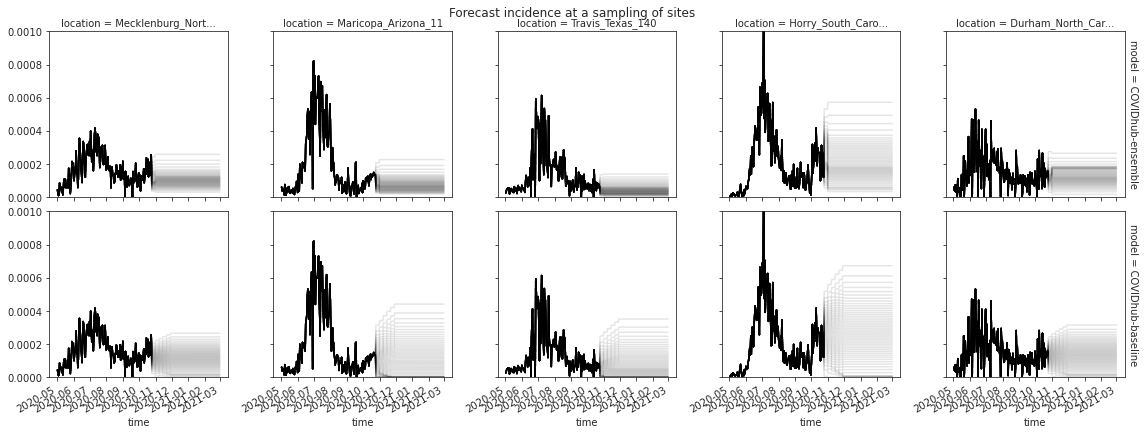

In [ ]:
locs = np.random.choice(c.location.values, size=5, replace=False)
incidence_model.sel(location=locs).plot.line(x='time', color='k', alpha=.1, add_legend=False, col='location', row='model')
plt.ylim(0.0, 1e-3)
plt.suptitle('Forecast incidence at a sampling of sites', y=1.0)
pass

# 3. Simulate the trial

Now that we've specified how the trial works, we can compute how the trial will turn out given the incidence forecasts you've specified. We do this by first imagining what sampling what incidence will be at all locations simultaneously. For any given fully-specified scenario, we compute how many participants will be under observation at any given time in any given location (in any given combination of demographic buckets), then based on the specified local incidence we compute how many will become infected, and how many will produce clinical events.

Here we assume that the incidence trajectories of different locations are drawn at random from the available forecasts. Other scenario-generation methods in `sim_scenarios` support more complex approaches. For example, we may be highly uncertain about the incidence at each site, but believe that if incidence is high at a site, then it will also be high at geographically nearby sites. If this is the case then the simulation should not choose forecasts independently at each site but instead should take these correlations into account.  The code scenario-generating methods in `sim_scenarios` allows us to do that.

In [ ]:
# incidence_flattened: rolls together all the models you've included in your ensemble, treating them as independent samples.
incidence_flattened = sim_scenarios.get_incidence_flattened(incidence_model, c)

# incidence_scenarios: chooses scenarios given the incidence curves and your chosen method of scenario-generation.
incidence_scenarios = sim_scenarios.generate_scenarios_independently(incidence_flattened, num_scenarios=100)

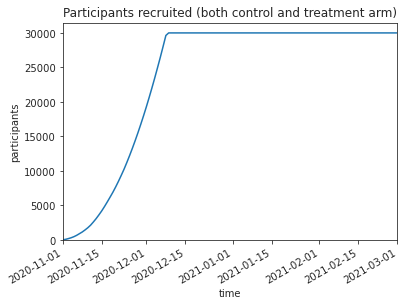

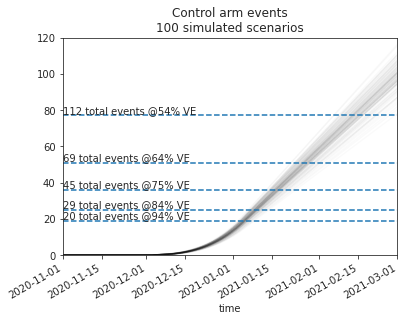

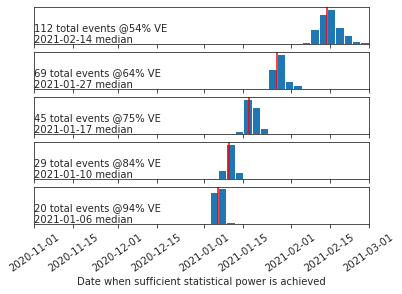

In [ ]:
# compute the number of participants recruited under your trial rule
participants = sim.recruitment(c)
# compute the number of control arm events under your trial rules and incidence_scenarios.
events = sim.control_arm_events(c, participants, incidence_scenarios)

plot_participants(participants)
# plot events and label different vaccine efficacies
plot_events(events)
# plot histograms of time to success
plot_success(c, events)

In [ ]:
sim.add_stuff_to_ville(c, incidence_model, site_df, num_scenarios=100)
!mkdir -p demo_output
metis_io.write_ville_to_netcdf(c, 'demo_output/site_list1_all_site_on.nc')

Populating participants.
Populating control_arm_events based on independent scenarios.


# 4. Optimize the trial

The simulations above supposed that all sites are activated as soon as possible (i.e. `site_activation` is identically 1). Now that we have shown the ability to simulate the outcome of the trial, we can turn it into a mathematical optimization problem. 

**Given the parameters of the trial within our control, how can we set those parameters to make the trial most likely to succeed or to succeed as quickly as possible?**

We imagine the main levers of control are which sites to activate or which sites to prioritize activating, and this is what is implemented here. 

However, the framework we have developed is very general and could be extended to just about anything you control which you can predict the impact of. For example,
* If you can estimate the impact of money spent boosting recruitment of high-risk participants, we could use those estimates to help figure out how to best allocate a fixed budget.
* If you had requirements for the number of people infected in different demographic groups, we could use those to help figure out how to best allocate doses between sites with different population characteristics.

The optimization algorithms are implemented in [JAX](https://github.com/google/jax), a  python library that makes it possible to differentiate through native python and numpy functions. The flexibility of the language makes it possible to compose a variety of trial optimization scenarios and then to write algorithms that find optima.  There are a number of technical details in how the optimization algorithms are written that will be discussed elsewhere.


### An example: Optimizing Static site activations

Suppose that the only variable we can control is which sites should be activated, and we have to make this decision at the beginning of the trial.  This decision is then set in stone for the duration of the trial.  To calculate this we proceed as follows:

The optimizer takes in the trial plan, encoded in the xarray `c` as well as the `incidence_scenarios`, and then calls the optimizer to find the sites that should be activated to minimize the time to success of the trial. The algorithm modifies `c` *in place*, so that after the algorithm runs, it returns the trial plan `c` but with the site activations chosen to be on or off in accordance with the optimizion.

In [ ]:
%time optimization.optimize_static_activation(c, incidence_scenarios)

Skipping jax conversion of subregion1_name (dtype is "object")
Skipping jax conversion of subregion2_name (dtype is "object")
Skipping jax conversion of opencovid_key (dtype is "object")
step 10, loss value -0.34960946440696716
step 20, loss value -0.36731186509132385
step 30, loss value -0.37567955255508423
step 40, loss value -0.379701167345047
step 50, loss value -0.38171371817588806
step 60, loss value -0.3827895224094391
step 70, loss value -0.38342612981796265
Skipping jax conversion of subregion1_name (dtype is "object")
Skipping jax conversion of subregion2_name (dtype is "object")
Skipping jax conversion of opencovid_key (dtype is "object")
CPU times: user 23.1 s, sys: 3.84 s, total: 27 s
Wall time: 18.1 s


### Plot the resulting sites

Now we can plot the activations for the resulting sites. Only a fraction (92/146) of the original sites are activated in the optimized plan. If you compare the distributions for the time to success for the optimized sites to those in the original trial plan, where all sites were activated equally, you will see that the optimized plan saves time for the trial.



96 of 146 activated


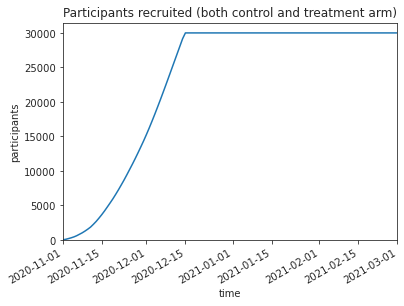

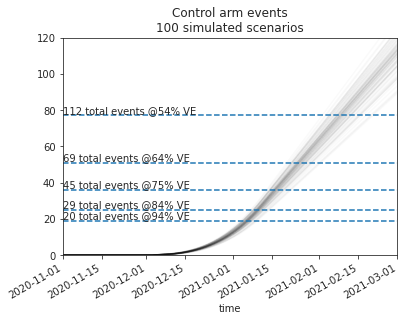

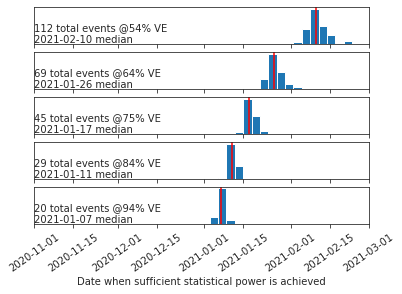

In [ ]:
all_sites = c.location.values
activated_sites = c.location.values[c.site_activation.mean('time') == 1]

# Simulate the results with this activation scheme.
print(f'\n\n{len(activated_sites)} of {len(all_sites)} activated')
participants = sim.recruitment(c)
events = sim.control_arm_events(c, participants, incidence_scenarios)
plot_participants(participants)
plot_events(events)
plot_success(c, events)

In [ ]:
sim.add_stuff_to_ville(c, incidence_model, site_df, num_scenarios=100)
!mkdir -p demo_output
metis_io.write_ville_to_netcdf(c, 'demo_output/site_list1_optimized_static.nc')

### Another example: prioritizing sites
Suppose we can activate up to 20 sites each week for 10 weeks. How do we prioritize them?

In [ ]:
# We put all sites in on group. We also support prioritizing sites within groupings.
# For example, if you can activate 2 sites per state per week, sites would be grouped
# according to the state they're in.
site_to_group = pd.Series(['all_sites'] * len(site_df), index=site_df.index)
decision_dates = c.time.values[:70:7]
allowed_activations = pd.DataFrame([[20] * len(decision_dates)], index=['all_sites'], columns=decision_dates)
parameterizer = optimization.PivotTableActivation(c, site_to_group, allowed_activations, can_deactivate=False)

In [ ]:
optimization.optimize_params(c, incidence_scenarios, parameterizer)
c['site_activation'] = c.site_activation.round()  # each site has to be on or off at each time

Skipping jax conversion of subregion1_name (dtype is "object")
Skipping jax conversion of subregion2_name (dtype is "object")
Skipping jax conversion of opencovid_key (dtype is "object")
step 10, loss value -0.3336004912853241
step 20, loss value -0.35643070936203003
step 30, loss value -0.3701512813568115
step 40, loss value -0.3754726052284241
step 50, loss value -0.3791292607784271
step 60, loss value -0.3817805349826813
step 70, loss value -0.3827342987060547
step 80, loss value -0.3833785951137543
Skipping jax conversion of subregion1_name (dtype is "object")
Skipping jax conversion of subregion2_name (dtype is "object")
Skipping jax conversion of opencovid_key (dtype is "object")


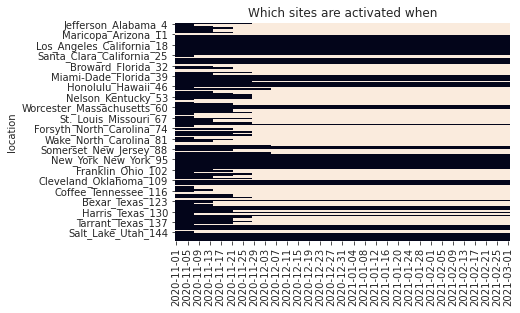

In [ ]:
df = c.site_activation.to_pandas()
df.columns = [pd.to_datetime(x).date() for x in df.columns]
sns.heatmap(df, cbar=False)
plt.title('Which sites are activated when')
plt.show()

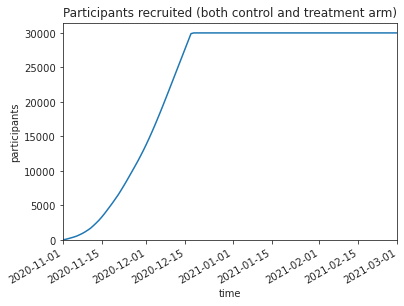

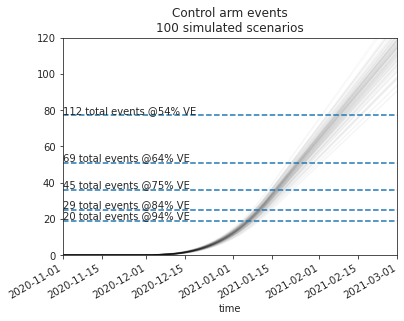

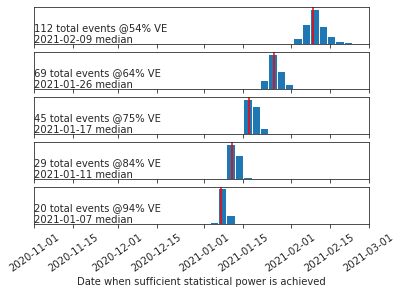

In [ ]:
participants = sim.recruitment(c)
events = sim.control_arm_events(c, participants, incidence_scenarios)
plot_participants(participants)
plot_events(events)
plot_success(c, events)

In [ ]:
sim.add_stuff_to_ville(c, incidence_model, site_df, num_scenarios=100)
!mkdir -p demo_output
metis_io.write_ville_to_netcdf(c, 'demo_output/site_list1_prioritized.nc')